In [23]:
import xarray as xr
from matplotlib import pyplot as plt

In [24]:
ds = xr.open_dataset('/import/beegfs/CMIP6/jdpaul3/hydroviz_testing/nc/combined.nc')
ds

<xarray.Dataset> Size: 5GB
Dimensions:    (stream_id: 56460, doy: 366, era: 4, landcover: 1, model: 1,
                scenario: 5)
Coordinates:
  * stream_id  (stream_id) int64 452kB 1 2 3 4 5 ... 56457 56458 56459 56460
  * doy        (doy) int64 3kB 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
  * model      (model) object 8B 'bcc-csm1-1'
  * scenario   (scenario) object 40B 'historical' 'rcp26' ... 'rcp60' 'rcp85'
  * landcover  (landcover) object 8B 'static'
  * era        (era) object 32B '1976-2005' '2016-2045' '2046-2075' '2071-2100'
Data variables:
    doy_min    (era, doy, landcover, model, scenario, stream_id) float32 2GB ...
    doy_mean   (era, doy, landcover, model, scenario, stream_id) float32 2GB ...
    doy_max    (era, doy, landcover, model, scenario, stream_id) float32 2GB ...
Attributes:
    title:         Combined Streamflow Daily Climatologies
    description:   Daily climatology statistics (min, mean, max) by era and m...
    created:       2025-11-24T13:30:06.926574
    source_files:  ['static_bcc-csm1-1_rcp60_r1i1p1_doy_mmm_by_era.nc', 'stat...

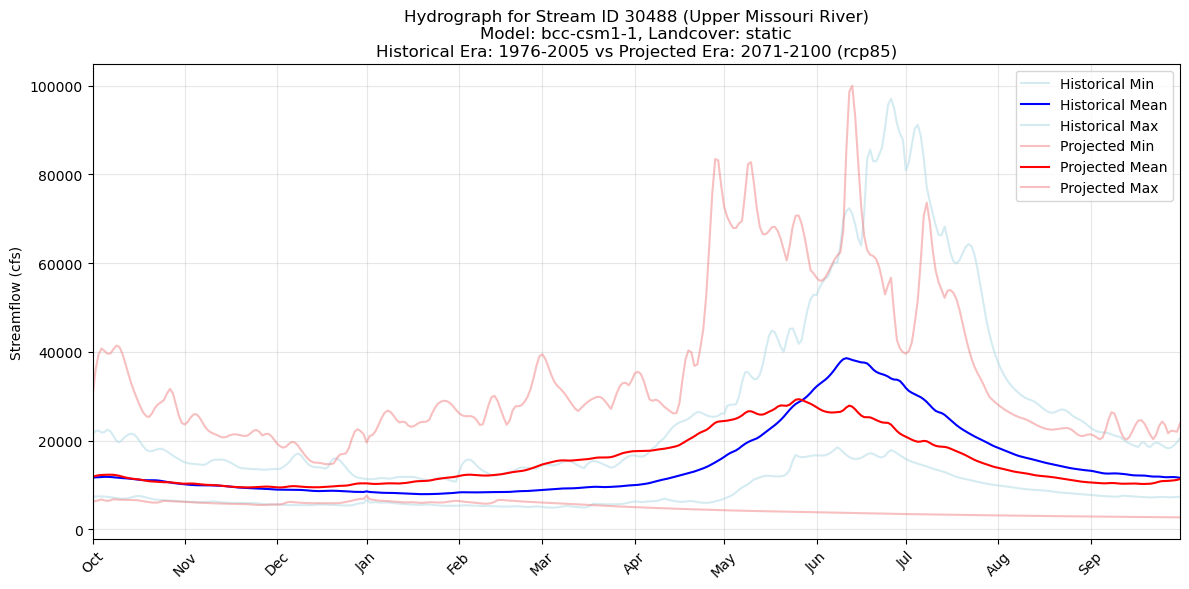

In [43]:
# plot historical vs projected hydrograph for a given stream
import numpy as np

stream_id = 30488
landcover = 'static'
model = 'bcc-csm1-1'
scenario = 'rcp85'
hist_era = '1976-2005'
proj_era = '2071-2100'

hydrograph_hist_min = ds['doy_min'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario="historical", era=hist_era)
hydrograph_hist_mean = ds['doy_mean'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario="historical", era=hist_era)
hydrograph_hist_max = ds['doy_max'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario="historical", era=hist_era)

hydrograph_proj_min = ds['doy_min'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario=scenario, era=proj_era)
hydrograph_proj_mean = ds['doy_mean'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario=scenario, era=proj_era)       
hydrograph_proj_max = ds['doy_max'].sel(stream_id=stream_id, landcover=landcover, model=model, scenario=scenario, era=proj_era)

# Create water year ordering: DOY 274-365, then 1-273
doy_values = ds['doy'].values
water_year_order = np.concatenate([
    np.arange(274, 367),  # Oct 1 (274) to Dec 31 (365)
    np.arange(1, 274)     # Jan 1 (1) to Sep 30 (273)
])

# Find the indices to reorder the data
reorder_indices = np.searchsorted(doy_values, water_year_order)

# Create water year DOY axis (0 to 365)
water_year_doy = np.arange(len(water_year_order))

# Reorder all the data arrays
hist_min_ordered = hydrograph_hist_min.values[reorder_indices]
hist_mean_ordered = hydrograph_hist_mean.values[reorder_indices]
hist_max_ordered = hydrograph_hist_max.values[reorder_indices]
proj_min_ordered = hydrograph_proj_min.values[reorder_indices]
proj_mean_ordered = hydrograph_proj_mean.values[reorder_indices]
proj_max_ordered = hydrograph_proj_max.values[reorder_indices]

# Create figure
plt.figure(figsize=(12, 6))

# Plot with properly ordered water year data
plt.plot(water_year_doy, hist_min_ordered, label='Historical Min', linestyle='-', color='lightblue', alpha=0.5)
plt.plot(water_year_doy, hist_mean_ordered, label='Historical Mean', linestyle='-', color='blue')
plt.plot(water_year_doy, hist_max_ordered, label='Historical Max', linestyle='-', color='lightblue', alpha=0.5)
plt.plot(water_year_doy, proj_min_ordered, label='Projected Min', linestyle='-', color='lightcoral', alpha=0.5)
plt.plot(water_year_doy, proj_mean_ordered, label='Projected Mean', linestyle='-', color='red')
plt.plot(water_year_doy, proj_max_ordered, label='Projected Max', linestyle='-', color='lightcoral', alpha=0.5)

plt.title(f'Hydrograph for Stream ID {stream_id} (Upper Missouri River)\nModel: {model}, Landcover: {landcover}\nHistorical Era: {hist_era} vs Projected Era: {proj_era} ({scenario})')

# Set x-axis limits and labels for water year
plt.xlim(0, 365)
#plt.xlabel('Days from Start of Water Year (Oct 1 = 0)')
plt.ylabel('Streamflow (cfs)')

# Add month labels for reference
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
# Approximate day of year for start of each month in water year
month_starts = [0, 31, 62, 92, 123, 151, 182, 212, 243, 273, 304, 335]
plt.xticks(month_starts, month_labels, rotation=45)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()